# Sobre as perguntas feitas da descrição do Lab

### 1 - Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)

Sim, os dados são desbalanceados. Obervando a distribuiçao, é possível perceber que a quantidade de candidatos não eleitos é bem maior que a quantidade de candidatos eleitos. É válido destacar que esse desbalanceamento não é advindo da coleta dos dados, pois realmente a quantidade de candidatos eleitos que entram para o congresso federal é bem menor que o total de candidatos. Em outros problemas, o desbalanceamento pode ser contornado com a geração artificial de amostras da classe em menor proporção. No entanto, para este problema de predição de candidatos eleitos e não eleitos o desbalanceamento é característica real da amostra, tornando o balanceamento artificial não praticável.

### 2 - Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)

Foram treinados 4 modelos e todos foram calibrados de acordo com suas caracteristicas utilizando validação cruzada. Os modelos foram: o Linear (ridge), Knn, DecisionTree e Xgboost.

### 3 - Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)

Todas as métricas foram reportadas em todos os modelos treinados. Além das métricas requisitadas, também foram reportados o f-measure a matriz de confusão.

### 4 - Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?  (2 pts.)

Avaliando anteriormente os atributos, vemos que muitos deles não são descriminatórios para o modelo como identificadores do canditado, partido, grau de escolaridade, profissão, entre outros mostrados durante o tratamento dos dados. Os mais discriminatórios são os dados quantitativos referentes aos gastos e doações que os canditados receberam, além de alguns dados categóricos como: sexo e estado.

### 5 - Envie seus melhores modelos à competição do Kaggle. Faça pelo menos uma submissão. Sugestões para melhorar o modelo: (2 pts.)

Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).
Experimente outras estratégias de ensembles (e.g. Stacking).
Experimente balancear as classes,  caso estejam desbalanceadas.

O resultado da predição que está construida atualmente neste notebook foi enviado e alcançou a 2º posição durante a fase de desenvolvimento. O modelo considerado no envio foi o Linear(Ridge), pois obteve os melhores resultados no teste e validação.

Os outros modelos obtiveram bons resultados nos testes, mas na validação não mantiveram o poder de generalização e o desbalanceamento acabou enviasando a classificação dos eleitos.

In [80]:
from sklearn.linear_model import Ridge, RidgeClassifier, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from scipy.stats import skew
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import itertools

import warnings
warnings.filterwarnings('ignore')

# Leitura dos Dados

In [81]:
train_test = pd.read_csv('train.csv', delimiter=',')
train_test_predict = pd.DataFrame(train_test['situacao'])
predict = pd.read_csv('test.csv', delimiter=',')
predict_code = predict['sequencial_candidato']

# Dados de Treino e Teste (2006/2010)

In [82]:
train_test.shape

(7622, 24)

In [83]:
train_test.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,situacao
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.67,0.0,...,14,14,16583.60,1184.54,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,nao_eleito
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.85,6625.0,...,24,23,20325.99,846.92,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,nao_eleito
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,158120.80,9301.22,2250.0,...,123,108,146011.70,1187.09,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,eleito
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.19,0.0,...,8,8,3001.12,375.14,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,nao_eleito
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,119820.00,2496.25,0.0,...,133,120,116416.64,875.31,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,eleito


In [84]:
train_test.tail()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,situacao
7617,2010,270000000264,ROBERTO PEREIRA URBANO,TO,PSC,3,3,3370.00,1123.33,370.00,...,16,16,3363.41,210.21,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),ADVOGADO,nao_eleito
7618,2010,270000000265,RONALDO DIMAS NOGUEIRA PEREIRA,TO,PR,715,706,1045323.16,1461.99,211804.58,...,1658,1275,815638.26,491.94,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),ENGENHEIRO,nao_eleito
7619,2010,270000000266,SÉRGIO PERIN,TO,PTB,2,2,2600.00,1300.00,0.00,...,2,2,2600.00,1300.00,DEPUTADO FEDERAL,MASCULINO,SUPERIOR INCOMPLETO,CASADO(A),ODONTÓLOGO,nao_eleito
7620,2010,270000000267,ÍTALO MARCEL COSTA CONCEIÇÃO,TO,PR,2,2,5175.00,2587.50,3375.00,...,2,2,5175.00,2587.50,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BANCÁRIO E ECONOMIÁRIO,nao_eleito
7621,2010,270000000501,LEONAM XAVIER GOMES,TO,PPS,13,12,36852.82,2834.83,30083.67,...,47,46,36739.62,781.69,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),SERVIDOR PÚBLICO FEDERAL,nao_eleito


In [88]:
pd.value_counts(train_test['situacao'])

nao_eleito    6596
eleito        1026
Name: situacao, dtype: int64

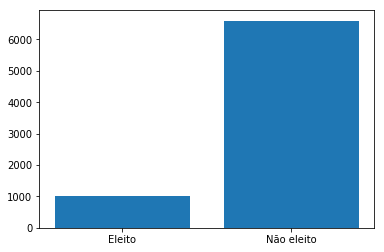

In [90]:
plt.bar(['Eleito', 'Não eleito'], [1026, 6596])
plt.show()

# Dados de Validação (2014)

In [6]:
predict.shape

(4592, 23)

In [7]:
predict.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao
0,2014,10000000135,EMERSON DA SILVA SANTOS,AC,PSOL,3,3,1580.00,526.67,0.00,...,80.0,3,3,1580.00,526.67,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),"CORRETOR DE IMÓVEIS, SEGUROS, TÍTULOS E VALORES"
1,2014,10000000142,GERALDO SILVA DOS SANTOS,AC,PSOL,5,5,3180.00,636.00,0.00,...,80.0,6,5,3130.02,521.67,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),VIGILANTE
2,2014,10000000158,CARLOS CESAR CORREIA DE MESSIAS,AC,PSB,40,38,336793.13,8419.83,1923.07,...,0.0,145,139,326869.78,2254.27,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL INCOMPLETO,CASADO(A),OUTROS
3,2014,10000000161,IDESIO LUIS FRANKE,AC,PT,29,29,156719.32,5404.11,39122.32,...,25000.0,136,121,241016.07,1772.18,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),AGRÔNOMO
4,2014,10000000163,LEONARDO CUNHA DE BRITO,AC,PT,160,146,737073.00,4606.71,10000.00,...,25000.0,518,354,567401.15,1095.37,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),ADVOGADO


In [8]:
predict.tail()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao
4587,2014,270000000304,JOENICE PEREIRA RIBEIRO,TO,PR,7,6,6482.29,926.04,6482.29,...,0.0,7,6,6334.29,904.90,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,CASADO(A),PROFESSOR DE ENSINO MÉDIO
4588,2014,270000000305,TIAGO DE PAULA ANDRINO,TO,PP,42,42,1738508.82,41393.07,54175.62,...,100000.0,646,492,1799447.74,2785.52,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),OUTROS
4589,2014,270000000312,ETEVALDO DA PAZ NONATO,TO,PSOL,3,3,1230.00,410.00,0.00,...,0.0,3,3,1230.00,410.00,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),ELETRICISTA E ASSEMELHADOS
4590,2014,270000000329,IVARDO SANTANA,TO,PSOL,2,2,900.00,450.00,0.00,...,0.0,2,2,900.00,450.00,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),ELETRICISTA E ASSEMELHADOS
4591,2014,270000000335,MARIA LUCIA SOARES VIANA,TO,PSOL,10,9,9895.00,989.50,0.00,...,0.0,26,23,9087.52,349.52,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,CASADO(A),ADMINISTRADOR


# Removendo Variáveis de Identificação e Informações Não Discriminatórias

In [9]:
train_test = train_test.drop(['partido', 'ocupacao' , 'sequencial_candidato', 'nome', 'grau', 'cargo', 'estado_civil', 'situacao'], axis=1)

In [10]:
predict = predict.drop(['partido', 'ocupacao' , 'sequencial_candidato', 'nome', 'grau', 'cargo', 'estado_civil'], axis=1)

In [11]:
train_test.head()

,ano,uf,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo
0,2006,AP,6,6,16600.00,2766.67,0.0,9000.0,6300.00,1300.0,0.0,14,14,16583.60,1184.54,MASCULINO
1,2006,RO,13,13,22826.00,1755.85,6625.0,15000.0,1000.00,201.0,0.0,24,23,20325.99,846.92,FEMININO
2,2006,AP,17,16,158120.80,9301.22,2250.0,34150.0,62220.80,59500.0,0.0,123,108,146011.70,1187.09,FEMININO
3,2006,MS,6,6,3001.12,500.19,0.0,1150.0,1101.12,750.0,0.0,8,8,3001.12,375.14,MASCULINO
4,2006,RO,48,48,119820.00,2496.25,0.0,50878.0,0.00,68942.0,0.0,133,120,116416.64,875.31,MASCULINO


In [12]:
train_test.tail()

,ano,uf,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo
7617,2010,TO,3,3,3370.00,1123.33,370.00,0.00,0.0,3000.00,0.0,16,16,3363.41,210.21,MASCULINO
7618,2010,TO,715,706,1045323.16,1461.99,211804.58,431518.58,173500.0,28500.00,200000.0,1658,1275,815638.26,491.94,MASCULINO
7619,2010,TO,2,2,2600.00,1300.00,0.00,0.00,0.0,600.00,2000.0,2,2,2600.00,1300.00,MASCULINO
7620,2010,TO,2,2,5175.00,2587.50,3375.00,1800.00,0.0,0.00,0.0,2,2,5175.00,2587.50,MASCULINO
7621,2010,TO,13,12,36852.82,2834.83,30083.67,500.00,0.0,6269.15,0.0,47,46,36739.62,781.69,MASCULINO


In [13]:
predict.head()

,ano,uf,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo
0,2014,AC,3,3,1580.00,526.67,0.00,1500.00,0.00,0.00,80.0,3,3,1580.00,526.67,MASCULINO
1,2014,AC,5,5,3180.00,636.00,0.00,3100.00,0.00,0.00,80.0,6,5,3130.02,521.67,MASCULINO
2,2014,AC,40,38,336793.13,8419.83,1923.07,65700.00,154170.06,115000.00,0.0,145,139,326869.78,2254.27,MASCULINO
3,2014,AC,29,29,156719.32,5404.11,39122.32,68783.84,17000.00,6813.16,25000.0,136,121,241016.07,1772.18,MASCULINO
4,2014,AC,160,146,737073.00,4606.71,10000.00,347073.00,277000.00,78000.00,25000.0,518,354,567401.15,1095.37,MASCULINO


In [14]:
predict.tail()

,ano,uf,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo
4587,2014,TO,7,6,6482.29,926.04,6482.29,0.0,0.0,0.0,0.0,7,6,6334.29,904.90,FEMININO
4588,2014,TO,42,42,1738508.82,41393.07,54175.62,260000.0,1311000.0,13333.2,100000.0,646,492,1799447.74,2785.52,MASCULINO
4589,2014,TO,3,3,1230.00,410.00,0.00,1230.0,0.0,0.0,0.0,3,3,1230.00,410.00,MASCULINO
4590,2014,TO,2,2,900.00,450.00,0.00,900.0,0.0,0.0,0.0,2,2,900.00,450.00,MASCULINO
4591,2014,TO,10,9,9895.00,989.50,0.00,1080.0,0.0,8815.0,0.0,26,23,9087.52,349.52,FEMININO


# Normalizando Variáveis Quantitativas

In [15]:
numeric_feats = train_test.dtypes[train_test.dtypes != "object"].index

skewed_feats = train_test[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

train_test[skewed_feats] = np.log1p(train_test[skewed_feats])

In [16]:
numeric_feats = predict.dtypes[predict.dtypes != "object"].index

skewed_feats = predict[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

predict[skewed_feats] = np.log1p(predict[skewed_feats])

In [17]:
train_test.head()

,ano,uf,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo
0,2006,AP,1.945910,1.945910,9.717218,7.925761,0.000000,9.105091,8.748464,7.170888,0.0,2.708050,2.708050,9.716230,7.077954,MASCULINO
1,2006,RO,2.639057,2.639057,10.035699,7.471278,8.798757,9.615872,6.908755,5.308268,0.0,3.218876,3.178054,9.919705,6.742786,FEMININO
2,2006,AP,2.890372,2.833213,11.971121,9.138008,7.719130,10.438547,11.038461,10.993748,0.0,4.820282,4.691348,11.891449,7.080102,FEMININO
3,2006,MS,1.945910,1.945910,8.007074,6.216985,0.000000,7.048386,7.004991,6.621406,0.0,2.197225,2.197225,8.007074,5.929961,MASCULINO
4,2006,RO,3.891820,3.891820,11.693754,7.822945,0.000000,10.837206,0.000000,11.141035,0.0,4.897840,4.795791,11.664939,6.775720,MASCULINO


In [18]:
train_test.tail()

,ano,uf,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo
7617,2010,TO,1.386294,1.386294,8.122965,7.024943,5.916202,0.000000,0.000000,8.006701,0.000000,2.833213,2.833213,8.121008,5.352853,MASCULINO
7618,2010,TO,6.573680,6.561031,13.859838,7.288238,12.263424,12.975068,12.063939,10.257694,12.206078,7.413970,7.151485,13.611727,6.200387,MASCULINO
7619,2010,TO,1.098612,1.098612,7.863651,7.170888,0.000000,0.000000,0.000000,6.398595,7.601402,1.098612,1.098612,7.863651,7.170888,MASCULINO
7620,2010,TO,1.098612,1.098612,8.551788,7.858834,8.124447,7.496097,0.000000,0.000000,0.000000,1.098612,1.098612,8.551788,7.858834,MASCULINO
7621,2010,TO,2.639057,2.564949,10.514715,7.950090,10.311771,6.216606,0.000000,8.743556,0.000000,3.871201,3.850148,10.511638,6.662737,MASCULINO


In [19]:
predict.head()

,ano,uf,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo
0,2014,AC,1.386294,1.386294,7.365813,6.268471,0.000000,7.313887,0.000000,0.000000,4.394449,1.386294,1.386294,7.365813,6.268471,MASCULINO
1,2014,AC,1.791759,1.791759,8.064951,6.456770,0.000000,8.039480,0.000000,0.000000,4.394449,1.945910,1.791759,8.049114,6.258950,MASCULINO
2,2014,AC,3.713572,3.663562,12.727227,9.038464,7.562198,11.092869,11.945818,11.652696,0.000000,4.983607,4.941642,12.697320,7.721025,MASCULINO
3,2014,AC,3.401197,3.401197,11.962218,8.595100,10.574474,11.138739,9.741027,8.826758,10.126671,4.919981,4.804021,12.392623,7.480530,MASCULINO
4,2014,AC,5.081404,4.990433,13.510444,8.435486,9.210440,12.757293,12.531776,11.264477,10.126671,6.251904,5.872118,13.248824,6.999760,MASCULINO


In [20]:
predict.tail()

,ano,uf,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo
4587,2014,TO,2.079442,1.945910,8.776983,6.831997,8.776983,0.000000,0.000000,0.000000,0.000000,2.079442,1.945910,8.753891,6.808929,FEMININO
4588,2014,TO,3.761200,3.761200,14.368539,10.630893,10.900005,12.468441,14.086302,9.498087,11.512935,6.472346,6.200509,14.402991,7.932549,MASCULINO
4589,2014,TO,1.386294,1.386294,7.115582,6.018593,0.000000,7.115582,0.000000,0.000000,0.000000,1.386294,1.386294,7.115582,6.018593,MASCULINO
4590,2014,TO,1.098612,1.098612,6.803505,6.111467,0.000000,6.803505,0.000000,0.000000,0.000000,1.098612,1.098612,6.803505,6.111467,MASCULINO
4591,2014,TO,2.397895,2.302585,9.199886,6.898210,0.000000,6.985642,0.000000,9.084324,0.000000,3.295837,3.178054,9.114767,5.859418,FEMININO


# Transformando Variáveis Categóricas

In [21]:
train_test['sexo'] = pd.Categorical(train_test['sexo'])
train_test['sexo'] = train_test.sexo.cat.codes

In [22]:
train_test_predict['situacao'] = pd.Categorical(train_test_predict['situacao'])
train_test_predict['situacao'] = train_test_predict.situacao.cat.codes

In [23]:
predict['sexo'] = pd.Categorical(predict['sexo'])
predict['sexo'] = predict.sexo.cat.codes

In [24]:
train_test = train_test.drop(['ano'], axis=1)
predict = predict.drop(['ano'], axis=1)

In [25]:
columns_categories = ['uf']
data_dummies = pd.get_dummies(pd.DataFrame(train_test[columns_categories]))
train_test = pd.concat([train_test, data_dummies], axis=1, sort=False)
train_test = train_test.drop(columns_categories, axis=1)

In [26]:
columns_categories = ['uf']
data_dummies = pd.get_dummies(pd.DataFrame(predict[columns_categories]))
predict = pd.concat([predict, data_dummies], axis=1, sort=False)
predict = predict.drop(columns_categories, axis=1)

In [27]:
train_test.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
0,1.945910,1.945910,9.717218,7.925761,0.000000,9.105091,8.748464,7.170888,0.0,2.708050,...,0,0,0,0,0,0,0,0,0,0
1,2.639057,2.639057,10.035699,7.471278,8.798757,9.615872,6.908755,5.308268,0.0,3.218876,...,0,0,0,1,0,0,0,0,0,0
2,2.890372,2.833213,11.971121,9.138008,7.719130,10.438547,11.038461,10.993748,0.0,4.820282,...,0,0,0,0,0,0,0,0,0,0
3,1.945910,1.945910,8.007074,6.216985,0.000000,7.048386,7.004991,6.621406,0.0,2.197225,...,0,0,0,0,0,0,0,0,0,0
4,3.891820,3.891820,11.693754,7.822945,0.000000,10.837206,0.000000,11.141035,0.0,4.897840,...,0,0,0,1,0,0,0,0,0,0


In [28]:
train_test.tail()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
7617,1.386294,1.386294,8.122965,7.024943,5.916202,0.000000,0.000000,8.006701,0.000000,2.833213,...,0,0,0,0,0,0,0,0,0,1
7618,6.573680,6.561031,13.859838,7.288238,12.263424,12.975068,12.063939,10.257694,12.206078,7.413970,...,0,0,0,0,0,0,0,0,0,1
7619,1.098612,1.098612,7.863651,7.170888,0.000000,0.000000,0.000000,6.398595,7.601402,1.098612,...,0,0,0,0,0,0,0,0,0,1
7620,1.098612,1.098612,8.551788,7.858834,8.124447,7.496097,0.000000,0.000000,0.000000,1.098612,...,0,0,0,0,0,0,0,0,0,1
7621,2.639057,2.564949,10.514715,7.950090,10.311771,6.216606,0.000000,8.743556,0.000000,3.871201,...,0,0,0,0,0,0,0,0,0,1


In [29]:
predict.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
0,1.386294,1.386294,7.365813,6.268471,0.000000,7.313887,0.000000,0.000000,4.394449,1.386294,...,0,0,0,0,0,0,0,0,0,0
1,1.791759,1.791759,8.064951,6.456770,0.000000,8.039480,0.000000,0.000000,4.394449,1.945910,...,0,0,0,0,0,0,0,0,0,0
2,3.713572,3.663562,12.727227,9.038464,7.562198,11.092869,11.945818,11.652696,0.000000,4.983607,...,0,0,0,0,0,0,0,0,0,0
3,3.401197,3.401197,11.962218,8.595100,10.574474,11.138739,9.741027,8.826758,10.126671,4.919981,...,0,0,0,0,0,0,0,0,0,0
4,5.081404,4.990433,13.510444,8.435486,9.210440,12.757293,12.531776,11.264477,10.126671,6.251904,...,0,0,0,0,0,0,0,0,0,0


In [30]:
predict.tail()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
4587,2.079442,1.945910,8.776983,6.831997,8.776983,0.000000,0.000000,0.000000,0.000000,2.079442,...,0,0,0,0,0,0,0,0,0,1
4588,3.761200,3.761200,14.368539,10.630893,10.900005,12.468441,14.086302,9.498087,11.512935,6.472346,...,0,0,0,0,0,0,0,0,0,1
4589,1.386294,1.386294,7.115582,6.018593,0.000000,7.115582,0.000000,0.000000,0.000000,1.386294,...,0,0,0,0,0,0,0,0,0,1
4590,1.098612,1.098612,6.803505,6.111467,0.000000,6.803505,0.000000,0.000000,0.000000,1.098612,...,0,0,0,0,0,0,0,0,0,1
4591,2.397895,2.302585,9.199886,6.898210,0.000000,6.985642,0.000000,9.084324,0.000000,3.295837,...,0,0,0,0,0,0,0,0,0,1


# Dados de Treinamento, Teste e Validação

In [31]:
data_train = train_test[:3581]
target_train = train_test_predict[:3581]

In [32]:
data_test = train_test[3581:]
target_test = train_test_predict[3581:]

In [33]:
data_predict = predict[:]

In [34]:
data_train.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
0,1.945910,1.945910,9.717218,7.925761,0.000000,9.105091,8.748464,7.170888,0.0,2.708050,...,0,0,0,0,0,0,0,0,0,0
1,2.639057,2.639057,10.035699,7.471278,8.798757,9.615872,6.908755,5.308268,0.0,3.218876,...,0,0,0,1,0,0,0,0,0,0
2,2.890372,2.833213,11.971121,9.138008,7.719130,10.438547,11.038461,10.993748,0.0,4.820282,...,0,0,0,0,0,0,0,0,0,0
3,1.945910,1.945910,8.007074,6.216985,0.000000,7.048386,7.004991,6.621406,0.0,2.197225,...,0,0,0,0,0,0,0,0,0,0
4,3.891820,3.891820,11.693754,7.822945,0.000000,10.837206,0.000000,11.141035,0.0,4.897840,...,0,0,0,1,0,0,0,0,0,0


In [35]:
data_train.tail()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
3576,1.791759,1.791759,7.386018,5.779045,6.656727,0.000000,0.000000,0.000000,6.728952,1.791759,...,0,0,0,0,0,0,0,0,1,0
3577,1.609438,1.609438,7.369160,5.984742,7.159525,0.000000,0.000000,5.707110,0.000000,1.609438,...,0,0,0,0,0,0,0,0,1,0
3578,1.098612,1.098612,6.723868,6.031910,0.000000,0.000000,0.000000,6.723868,0.000000,1.386294,...,0,0,0,0,0,0,0,0,1,0
3579,1.945910,1.945910,7.381589,5.592925,0.000000,6.857514,6.196729,5.111988,0.000000,2.639057,...,0,0,0,0,0,0,0,0,1,0
3580,3.332205,3.295837,11.974589,8.678916,9.780327,11.469297,10.633473,7.767294,7.243227,4.521789,...,0,0,0,0,0,0,0,0,1,0


In [36]:
data_test.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
3581,3.610918,3.583519,12.972221,9.388784,12.503138,10.975944,8.926358,11.463068,0.000000,4.007333,...,0,0,0,0,0,0,0,0,0,0
3582,1.386294,1.386294,8.852379,7.754053,0.000000,0.000000,8.610866,7.313887,0.000000,1.386294,...,0,0,0,0,0,0,0,0,0,0
3583,1.386294,1.386294,7.518064,6.420532,5.673323,7.313887,0.000000,3.931826,0.000000,1.386294,...,0,0,0,0,0,0,0,0,0,0
3584,0.693147,0.693147,6.089045,6.089045,6.089045,0.000000,0.000000,0.000000,0.000000,0.693147,...,0,0,0,0,0,0,0,0,0,0
3585,2.772589,2.639057,12.744614,10.036604,0.000000,8.716208,11.100451,9.296610,12.466516,4.430817,...,0,0,0,0,0,0,0,0,0,0


In [37]:
data_test.tail()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
7617,1.386294,1.386294,8.122965,7.024943,5.916202,0.000000,0.000000,8.006701,0.000000,2.833213,...,0,0,0,0,0,0,0,0,0,1
7618,6.573680,6.561031,13.859838,7.288238,12.263424,12.975068,12.063939,10.257694,12.206078,7.413970,...,0,0,0,0,0,0,0,0,0,1
7619,1.098612,1.098612,7.863651,7.170888,0.000000,0.000000,0.000000,6.398595,7.601402,1.098612,...,0,0,0,0,0,0,0,0,0,1
7620,1.098612,1.098612,8.551788,7.858834,8.124447,7.496097,0.000000,0.000000,0.000000,1.098612,...,0,0,0,0,0,0,0,0,0,1
7621,2.639057,2.564949,10.514715,7.950090,10.311771,6.216606,0.000000,8.743556,0.000000,3.871201,...,0,0,0,0,0,0,0,0,0,1


In [38]:
data_predict.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
0,1.386294,1.386294,7.365813,6.268471,0.000000,7.313887,0.000000,0.000000,4.394449,1.386294,...,0,0,0,0,0,0,0,0,0,0
1,1.791759,1.791759,8.064951,6.456770,0.000000,8.039480,0.000000,0.000000,4.394449,1.945910,...,0,0,0,0,0,0,0,0,0,0
2,3.713572,3.663562,12.727227,9.038464,7.562198,11.092869,11.945818,11.652696,0.000000,4.983607,...,0,0,0,0,0,0,0,0,0,0
3,3.401197,3.401197,11.962218,8.595100,10.574474,11.138739,9.741027,8.826758,10.126671,4.919981,...,0,0,0,0,0,0,0,0,0,0
4,5.081404,4.990433,13.510444,8.435486,9.210440,12.757293,12.531776,11.264477,10.126671,6.251904,...,0,0,0,0,0,0,0,0,0,0


In [39]:
data_predict.tail()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
4587,2.079442,1.945910,8.776983,6.831997,8.776983,0.000000,0.000000,0.000000,0.000000,2.079442,...,0,0,0,0,0,0,0,0,0,1
4588,3.761200,3.761200,14.368539,10.630893,10.900005,12.468441,14.086302,9.498087,11.512935,6.472346,...,0,0,0,0,0,0,0,0,0,1
4589,1.386294,1.386294,7.115582,6.018593,0.000000,7.115582,0.000000,0.000000,0.000000,1.386294,...,0,0,0,0,0,0,0,0,0,1
4590,1.098612,1.098612,6.803505,6.111467,0.000000,6.803505,0.000000,0.000000,0.000000,1.098612,...,0,0,0,0,0,0,0,0,0,1
4591,2.397895,2.302585,9.199886,6.898210,0.000000,6.985642,0.000000,9.084324,0.000000,3.295837,...,0,0,0,0,0,0,0,0,0,1


# Validação Cruzada

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)

    return plt

In [41]:
def confusion_val(classifier, X_train, Y_train, cv):
    y_pred = cross_val_predict(classifier, X_train, Y_train, cv=cv)
    cm = confusion_matrix(Y_train, y_pred)
    fig = plt.figure(figsize=(5, 5))
    plot = plot_confusion_matrix(cm, classes=['Eleito','Não Eleito'], normalize=False, title='Matriz de Confusão')
    plt.show()

In [42]:
def sample_confusion_val(Y_train, y_pred):
    cm = confusion_matrix(Y_train, y_pred)
    fig = plt.figure(figsize=(5, 5))
    plot = plot_confusion_matrix(cm, classes=['Eleito','Não Eleito'], normalize=False, title='Matriz de Confusão')
    plt.show()

In [43]:
def cross_val(classifier, X_train, Y_train, cv):
    acc = cross_val_score(classifier, X_train, Y_train.round(), cv=cv)
    prec = cross_val_score(classifier, X_train, Y_train, scoring='precision', cv=cv)
    rec = cross_val_score(classifier, X_train, Y_train, scoring='recall', cv=cv)
    f1 = cross_val_score(classifier, X_train, Y_train, scoring='f1', cv=cv)
    roc_auc = cross_val_score(classifier, X_train, Y_train, scoring='roc_auc', cv=cv)
    
    print("Accuracy: %.2f%% (%.2f%%)" % (np.ma.median(acc) * 100, acc.std() * 100))
    print("Precision: %.2f%% (%.2f%%)" % (np.ma.median(prec) * 100, prec.std() * 100))
    print("Recall: %.2f%% (%.2f%%)" % (np.ma.median(rec) * 100, rec.std() * 100))
    print("F-measure: %.2f%%, (%.2f%%)" % (np.ma.median(f1) * 100,f1.std() * 100))
    print("ROC AUC: %.2f%%, (%.2f%%)" % (np.ma.median(roc_auc) * 100,roc_auc.std() * 100))


In [44]:
def submit_data(codes, target):
    
    predict = list()
    
    for code, y in zip(codes, target):
        if y == 1:
            goal = list([str(code), str("nao_eleito")])
        else:
            goal = list([str(code), str("eleito")])
            
        predict.append(goal)
        
    df = pd.DataFrame(predict, columns=[str("Id"),str("Predicted")])
    
    df.to_csv("predict_2014.csv",index=False)
    
    return df

In [73]:
cv = StratifiedKFold(n_splits=100, random_state=5)

# Modelo Linear

In [1247]:
params = {'alpha':[0.3,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.45]}

model_r = GridSearchCV(RidgeClassifier(), param_grid=params, n_jobs=10, cv=cv)

model_r.fit(data_train, target_train['situacao'])

print("Melhores Parâmetros:",model_r.best_params_) 

Melhores Parâmetros: {'alpha': 0.36}


### Treinamento

In [55]:
model_r = RidgeClassifier(alpha=0.36)

In [56]:
cross_val(model_r, data_train, target_train['situacao'], cv)

Accuracy: 89.19% (3.77%)
Precision: 90.91% (3.24%)
Recall: 98.39% (3.74%)
F-measure: 93.94%, (2.20%)
ROC AUC: 95.48%, (4.26%)


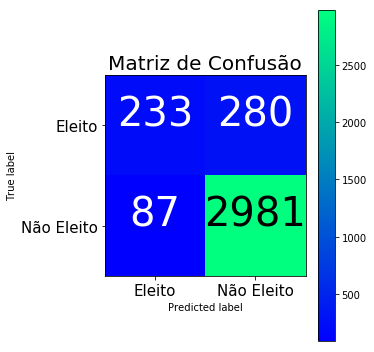

In [57]:
confusion_val(model_r, data_train, target_train['situacao'], cv)

### Teste

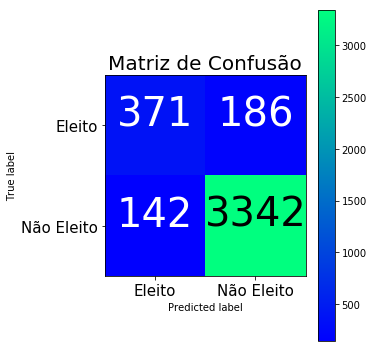

In [58]:
sample_confusion_val(model_r.fit(data_train, target_train['situacao']).predict(data_test), target_test['situacao'])

# Modelo KNN

In [46]:
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10],
          'leaf_size':[1,2,3,4,5,6,7,8,9,10],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute']}

model_knn = GridSearchCV(KNeighborsClassifier(n_jobs=10), param_grid=params, n_jobs=10, cv=cv)

model_knn.fit(data_train, target_train['situacao'])

print("Melhores Parâmetros:",model_knn.best_params_) 

Melhores Parâmetros: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 10, 'weights': 'uniform'}


### Treinamento

In [64]:
model_knn = KNeighborsClassifier(n_jobs=10, algorithm='auto', leaf_size= 1, n_neighbors=10, weights='uniform')

In [65]:
cross_val(model_knn, data_train, target_train['situacao'], cv)

Accuracy: 90.10% (2.36%)
Precision: 94.38% (1.35%)
Recall: 94.46% (3.10%)
F-measure: 94.18%, (1.47%)
ROC AUC: 92.40%, (2.20%)


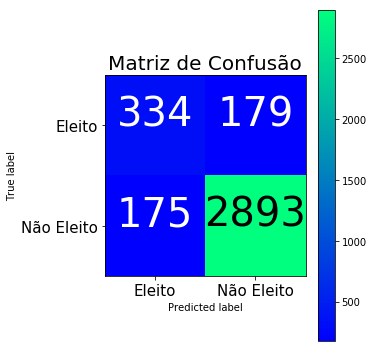

In [66]:
confusion_val(model_knn, data_train, target_train['situacao'], cv)

### Teste

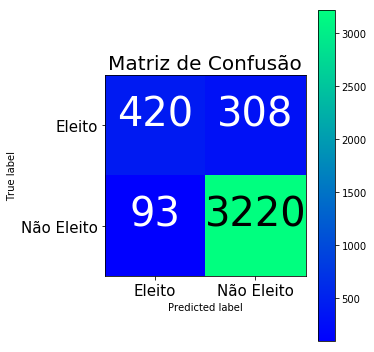

In [67]:
sample_confusion_val(model_knn.fit(data_train, target_train['situacao']).predict(data_test), target_test['situacao'])

# Modelo DesicionTree

In [59]:
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split':[2,3,4,5,6,7,8,9,10,11], 
          'min_samples_leaf':[2,3,4,5,6,7,8,9,10,11]}

model_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=params, n_jobs=10, cv=cv)

model_dt.fit(data_train, target_train['situacao'])

print("Melhores Parâmetros:",model_dt.best_params_)

Melhores Parâmetros: {'max_features': 'auto', 'min_samples_leaf': 11, 'min_samples_split': 7}


### Treinamento

In [60]:
model_dt = DecisionTreeClassifier(max_features='auto', min_samples_leaf=11, min_samples_split= 7)

In [61]:
cross_val(model_dt, data_train, target_train['situacao'], cv)

Accuracy: 90.24% (2.08%)
Precision: 93.73% (0.86%)
Recall: 93.32% (2.89%)
F-measure: 94.09%, (1.17%)
ROC AUC: 91.17%, (2.84%)


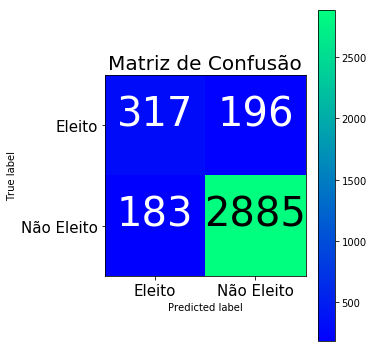

In [62]:
confusion_val(model_dt, data_train, target_train['situacao'], cv)

### Teste

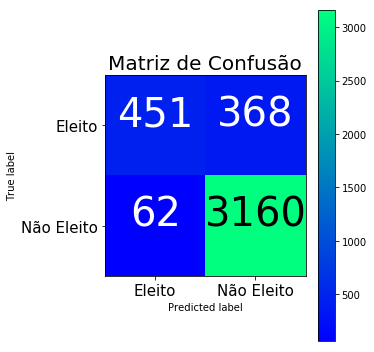

In [63]:
sample_confusion_val(model_dt.fit(data_train, target_train['situacao']).predict(data_test), target_test['situacao'])

# Modelo XGBoost

In [58]:
params = {'max_depth':[1,6,11],
          'min_child_weight':[0.00001,0.0001,0.001,0.1,1],
          'gamma':[0.00001,0.0001,0.001,0.1,1],
          'subsample':[0.00001,0.0001,0.001,0.1,1],
          'colsample_bytree':[0.00001,0.0001,0.001,0.1,1],
          'reg_alpha':[0.00001,0.0001,0.001,0.1,1]}
        
model_xg = GridSearchCV(XGBClassifier(n_jobs=10), param_grid=params, n_jobs=10, cv=cv)

model_xg.fit(data_train, target_train['situacao'])

print("Melhores Parâmetros:",model_xg.best_params_)

Melhores Parâmetros: {'colsample_bytree': 0.1, 'gamma': 1, 'max_depth': 11, 'min_child_weight': 1e-05, 'reg_alpha': 1e-05, 'subsample': 1}


### Treinamento

In [68]:
model_xg = XGBClassifier(n_jobs=10, colsample_bytree=0.1, gamma=1, max_depth=11, min_child_weight=1e-05, reg_alpha=1e-05, subsample=1)

In [69]:
cross_val(model_xg, data_train, target_train['situacao'], cv)

Accuracy: 91.75% (2.24%)
Precision: 94.87% (1.26%)
Recall: 95.77% (2.76%)
F-measure: 95.20%, (1.36%)
ROC AUC: 95.18%, (1.94%)


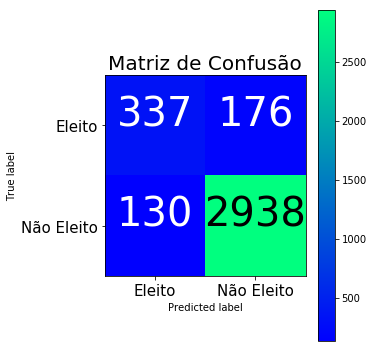

In [70]:
confusion_val(model_xg, data_train, target_train['situacao'], cv)

### Teste

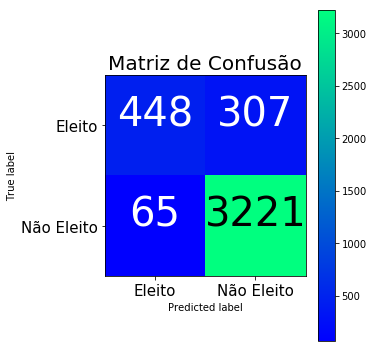

In [71]:
sample_confusion_val(model_xg.fit(data_train, target_train['situacao']).predict(data_test), target_test['situacao'])

# Predição

In [1147]:
RidgeClassifier(alpha=0.36)

model.fit(train_test, train_test_predict)

target = model.predict(predict)

In [1148]:
predict_2014 = submit_data(predict_code, target)

In [1149]:
predict_2014

,Id,Predicted
0,10000000135,nao_eleito
1,10000000142,nao_eleito
2,10000000158,nao_eleito
3,10000000161,nao_eleito
4,10000000163,eleito
5,10000000164,nao_eleito
6,10000000166,eleito
7,10000000169,nao_eleito
8,10000000170,nao_eleito
9,10000000171,eleito
